# FISH - Pipeline - A Python interactive notebook to process FISH data

```
Author: Luis U. Aguilera
Contact Info: luis.aguilera@colostate.edu

Copyright (c) 2021 Munsky Group 
Colorado State University 
Licensed under BSD 3-Clause License.
```

### Notebook summary 


- Load a directory with microscope FISH images
- Establish a connection to Network-attached storage (NAS) using [pysmb](https://github.com/miketeo/pysmb)
- Perform cell segmentation using [Cellpose](https://github.com/MouseLand/cellpose)
- Perform spot detection using [Big-FISH](https://github.com/fish-quant/big-fish)
- Datamanagement using Pandas

----

<img src= /home/luisub/Desktop/FISH_Processing/docs/images/code_architecture.png alt="drawing" width="1000"/>

### Libraries

In [1]:
# Importing libraries
import sys
import matplotlib.pyplot as plt 
import numpy as np 
import pathlib
import warnings
import shutil
import zipfile
import os
import re
import glob
import tifffile
from skimage.io import imread
warnings.filterwarnings("ignore")

### Path to source directories

In [2]:
# Deffining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

----

# Parameters defined by the user 

----

### Paths to images

In [3]:
# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
path_to_config_file = desktop_path.joinpath('config.yml')

### Remote directories
data_folder_path =pathlib.Path('Users/Michael/data/users/mpmay/acquisition/ForLuis_4Color_7_12_2022_1/Full resolution' )
path_to_masks_dir = None   # full path to a zip file
download_data_from_NAS = True
send_data_to_NAS=False

#### Local directories
#data_folder_path = current_dir.parents[0].joinpath('dataBases').joinpath('los_alamos_sample')
#path_to_masks_dir = None #current_dir.parents[0].joinpath('dataBases').joinpath('masks_test_data')
#download_data_from_NAS = True
#send_data_to_NAS=False

### Parameters for segmentation and spot detection

In [4]:
# Parameters fo cell segmentation 
channels_with_cytosol =  [0,2]             # list or int indicating the channels where the cytosol is detectable
channels_with_nucleus = [1]           # list or int indicating the channels where the nucleus is detectable
channels_with_FISH = [2]              # list or int with the channels with FISH spots that are used for the quantification
diameter_nucleus = 200                # approximate nucleus size in pixels
diameter_cytosol = 300                # approximate cytosol size in pixels

# Parameters for FISH detection
voxel_size_z = 500    #300                      # Microscope conversion px to nanometers in the z axis.
voxel_size_yx = 103 #103   #103                 # Microscope conversion px to nanometers in the xy axis.
psf_z = 350      #350                           # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers.
psf_yx = 120     #150                           # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers.
list_voxels = [ voxel_size_z,voxel_size_yx ]
list_psfs = [psf_z, psf_yx ]

# Cluster Detection
minimum_spots_cluster = 2                  # The number of spots in a neighborhood for a point to be considered as a core point (from which a cluster is expanded). This includes the point itself.
show_plots = True                          # Flag to display plots
optimization_segmentation_method = None    # optimization_segmentation_method = 'intensity_segmentation' 'z_slice_segmentation', 'gaussian_filter_segmentation' ,  'center_slice', None
save_all_images=False                     # If true, it shows a all planes for the FISH plot detection. 
threshold_for_spot_detection = None       # Intensity threshold to detect  spots. If None, it will automatically detect the spots.
use_brute_force=False

In [5]:
# names for final folders
name_final_folder = data_folder_path.name +'___nuc_' + str(diameter_nucleus) + '__cyto_' + str(diameter_cytosol) + '__psfz_' + str(psf_z) + '__psfyx_' + str(psf_yx) 


## Connecting to NAS and Downloading data

In [6]:
def download_data_NAS(path_to_config_file,data_folder_path, path_to_masks_dir,share_name,timeout=200):
    # Downloading data from NAS
    local_folder_path = pathlib.Path().absolute().joinpath('temp_' + data_folder_path.name)
    fa.NASConnection(path_to_config_file,share_name = share_name).copy_files(data_folder_path, local_folder_path,timeout=timeout)
    local_data_dir = local_folder_path     # path to a folder with images.
    # Downloading masks from NAS
    if not (path_to_masks_dir is None):
        local_folder_path_masks = pathlib.Path().absolute().joinpath( path_to_masks_dir.stem  )
        zip_file_path = local_folder_path_masks.joinpath( path_to_masks_dir.stem +'.zip')
        print(zip_file_path)
        fa.NASConnection(path_to_config_file,share_name = share_name).download_file(path_to_masks_dir, local_folder_path_masks,timeout=timeout)
        # Unzip downloaded images and update mask directory
        file_to_unzip = zipfile.ZipFile(str(zip_file_path)) # opens zip
        # Iterates for each file in zip file
        for file_in_zip in file_to_unzip.namelist():
            # Extracts data to specific folder
            file_to_unzip.extract(file_in_zip,local_folder_path_masks)
        # Closes the zip file
        file_to_unzip.close()
        # removes the original zip file
        os.remove(zip_file_path)
        masks_dir = local_folder_path_masks
    else:
        masks_dir = None
    return local_data_dir, masks_dir

In [7]:
# Download data from NAS
if download_data_from_NAS == True:
    share_name = 'share'
    local_data_dir, masks_dir= download_data_NAS(path_to_config_file,data_folder_path, path_to_masks_dir,share_name,timeout=200)
else:
    local_data_dir = data_folder_path 
    masks_dir = path_to_masks_dir 

Connection established
File Downloaded : ForLuis_4Color_7_12_2022_NDTiffStack.tif
Files downloaded to: /home/luisub/Desktop/FISH_Processing/notebooks/temp_Full resolution


In [8]:
list_images, path_files, list_files_names, number_images = fa.ReadImages(directory= local_data_dir).read()
print('image_shape: ', list_images[0].shape)


# Imaging order=[405nm, 640nm, 561nm, 488nm]

image_shape:  (11, 512, 512)


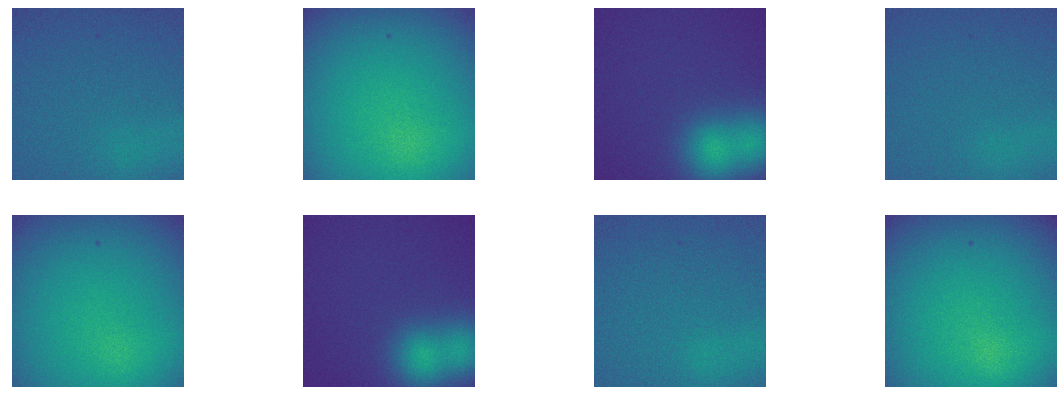

In [20]:
fig, ax = plt.subplots(2,4, figsize=(20, 7))
counter=0
for z in range (2):
    for i in range(4):
        ax[z,i].imshow(list_images[0][counter,:,:])
        ax[z,i].grid(False); ax[z,i].set_xticks([]); ax[z,i].set_yticks([])
        counter+=1

In [9]:
raise

RuntimeError: No active exception to reraise

In [ ]:
def merge_files(list_images_to_merge, file_name_merged_image, save_to_path ):
    merged_img = np.concatenate([ imread(list_images_to_merge[i])[..., np.newaxis] for i,_ in enumerate(list_images_to_merge)],axis=-1).astype('uint16')
    tifffile.imsave(save_to_path.joinpath(file_name_merged_image), merged_img, metadata={'axes': 'ZYXC'})
    return None

In [ ]:
# creating a subdirectory to store merged images
merged_files_path = local_data_dir.joinpath('merged')
if not os.path.exists(str(merged_files_path)):
    os.makedirs(str(merged_files_path))
merged_files_path

In [ ]:
for i in range(0, len(list_merge_file_names)):
    merge_files(list_sorted_filenames[i], list_merge_file_names[i], merged_files_path )

In [ ]:
local_data_dir = merged_files_path

## Running the pipeline

----

In [ ]:
dataframe_FISH,_,_,_ = fa.PipelineFISH(local_data_dir, channels_with_cytosol, channels_with_nucleus, channels_with_FISH,diameter_nucleus, diameter_cytosol, minimum_spots_cluster, masks_dir=masks_dir,  list_voxels=list_voxels, list_psfs=list_psfs, show_plot=show_plots, file_name_str =data_folder_path.name, optimization_segmentation_method = optimization_segmentation_method,save_all_images=save_all_images,threshold_for_spot_detection=threshold_for_spot_detection,use_brute_force=True  ).run()

## Extracting data from the dataframe

----

In [ ]:
# Be aware that the code keeps track of cells without spots. In the data frame, the fields for cells without spots are populated with -1 values.
dataframe_FISH.tail()

In [ ]:
# Number of cells
spot_type_selected = 0
number_cells = dataframe_FISH['cell_id'].nunique()
print(number_cells)
# Number of spots
number_of_spots_per_cell = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i)  & (dataframe_FISH['spot_type']==spot_type_selected) & (dataframe_FISH['is_cell_fragmented']!=-1) ].spot_id) for i in range(0, number_cells)]
# Number of spots in cytosol
number_of_spots_per_cell_cytosol = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) & (dataframe_FISH['is_nuc']==False) & (dataframe_FISH['spot_type']==spot_type_selected) & (dataframe_FISH['is_cell_fragmented']!=-1) ].spot_id) for i in range(0, number_cells)]
# Number of spots in nucleus
number_of_spots_per_cell_nucleus = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) &  (dataframe_FISH['is_cluster']==False) & (dataframe_FISH['is_nuc']==True) & (dataframe_FISH['spot_type']==spot_type_selected)  & (dataframe_FISH['is_cell_fragmented']!=-1)   ].spot_id) for i in range(0, number_cells)]
# Number of TS per cell.
number_of_TS_per_cell = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) &  (dataframe_FISH['is_cluster']==True) & (dataframe_FISH['is_nuc']==True) & (dataframe_FISH['spot_type']==spot_type_selected) & (dataframe_FISH['cluster_size'] >=minimum_spots_cluster) & (dataframe_FISH['is_cell_fragmented']!=-1) ].spot_id) for i in range(0, number_cells)]
# Number of RNA in a TS
ts_size =  dataframe_FISH.loc[   (dataframe_FISH['is_cluster']==True) & (dataframe_FISH['is_nuc']==True)  & (dataframe_FISH['spot_type']==spot_type_selected) & (dataframe_FISH['is_cell_fragmented']!=-1)  ].cluster_size.values
# Size of each cell
cell_size = dataframe_FISH.loc[  (dataframe_FISH['spot_id']==0)  |  (dataframe_FISH['spot_id']==-1)  ].cell_area_px.values

## Plotting

----

In [ ]:
# Plotting intensity distributions
plt.style.use('ggplot')  # ggplot  #default
def plot_probability_distribution(data_to_plot, numBins = 10, title='', xlab='', ylab='', color='r', subplots=False, show_grid=True, fig=plt.figure() ):
  n, bins, _ = plt.hist(data_to_plot,bins=numBins,density=False,color=color)
  plt.xlabel(xlab, size=16)
  plt.ylabel(ylab, size=16)
  plt.grid(show_grid)
  plt.text(bins[(len(bins)//2)],(np.amax(n)//2).astype(int),'mean = '+str(round( np.mean(data_to_plot) ,1) ), fontsize=14,bbox=dict(facecolor='w', alpha=0.5) )
  plt.title(title, size=16)
  return (f)

In [ ]:
#Plotting
fig_size = (30, 7)
f = plt.figure(figsize=fig_size)
#ylab='Probability'
ylab='Frequency Count'  
# adding subplots
f.add_subplot(1,5,1) 
plot_probability_distribution( number_of_spots_per_cell, numBins=20,  title='Total Num Spots per cell', xlab='Number', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,2) 
plot_probability_distribution(number_of_spots_per_cell_cytosol,   numBins=20,  title='Num Spots in Cytosol', xlab='Number', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,3) 
plot_probability_distribution(number_of_spots_per_cell_nucleus, numBins=20,    title='Num Spots in Nucleus', xlab='Number', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,4) 
plot_probability_distribution(ts_size, numBins=20,    title='Clusters in nucleus', xlab='RNA per Cluster', ylab=ylab, fig=f, color='orangered')
f.add_subplot(1,5,5) 
plot_probability_distribution(number_of_TS_per_cell ,  numBins=20, title='Number TS per cell', xlab='[TS (>= 4 rna)]', ylab=ylab, fig=f, color='orangered')
plt.savefig('plots_'+data_folder_path.name+'.png')
plt.show()

## Saving results

In [ ]:
# create results folder
if not os.path.exists(str('analysis_'+ name_final_folder)):
    os.makedirs(str('analysis_'+ name_final_folder))    

#figure_path 
pathlib.Path().absolute().joinpath('plots_'+ data_folder_path.name +'.png').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ name_final_folder),'plots_'+ data_folder_path.name +'.png'))
#metadata_path
pathlib.Path().absolute().joinpath('metadata_'+ data_folder_path.name +'.txt').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ name_final_folder),'metadata_'+ data_folder_path.name +'.txt'))
#dataframe_path 
pathlib.Path().absolute().joinpath('dataframe_' + data_folder_path.name +'.csv').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ name_final_folder),'dataframe_'+ data_folder_path.name +'.csv'))
#pdf_path 
pathlib.Path().absolute().joinpath('pdf_report_' + data_folder_path.name +'.pdf').rename(pathlib.Path().absolute().joinpath(str('analysis_'+ name_final_folder    ),'pdf_report_'+ data_folder_path.name +'.pdf'))

## Sending results to NAS

----

In [ ]:
# Writing analyses data to NAS
analysis_folder_name = 'analysis_'+ name_final_folder
if send_data_to_NAS == True:
    shutil.make_archive(analysis_folder_name,'zip',pathlib.Path().absolute().joinpath(analysis_folder_name))
    local_file_to_send_to_NAS = pathlib.Path().absolute().joinpath(analysis_folder_name+'.zip')
    fa.NASConnection(path_to_config_file,share_name = share_name).write_files_to_NAS(local_file_to_send_to_NAS, data_folder_path)
    os.remove(pathlib.Path().absolute().joinpath(analysis_folder_name+'.zip'))

In [ ]:
# Writing masks to NAS
if path_to_masks_dir == None: 
    mask_folder_created_by_pipeline = 'masks_'+ data_folder_path.name # default name by pipeline
    name_final_masks = data_folder_path.name +'___nuc_' + str(diameter_nucleus) + '__cyto_' + str(diameter_cytosol) 
    mask_dir_complete_name = 'masks_'+ name_final_masks # final name for masks dir
    shutil.move(mask_folder_created_by_pipeline, mask_dir_complete_name ) # remaing the masks dir
else: 
    mask_dir_complete_name = masks_dir.name
    
if (send_data_to_NAS == True) and (path_to_masks_dir == None) :
    shutil.make_archive( mask_dir_complete_name , 'zip', pathlib.Path().absolute().joinpath(mask_dir_complete_name))
    local_file_to_send_to_NAS = pathlib.Path().absolute().joinpath(mask_dir_complete_name+'.zip')
    fa.NASConnection(path_to_config_file,share_name = share_name).write_files_to_NAS(local_file_to_send_to_NAS, data_folder_path)
    os.remove(pathlib.Path().absolute().joinpath(mask_dir_complete_name+'.zip'))

## Removing temporal local files

----

In [ ]:
# Moving all results to "analyses" folder
if not os.path.exists(str('analyses')):
    os.makedirs(str('analyses'))

# Subfolder name
final_dir_name =pathlib.Path().absolute().joinpath('analyses', analysis_folder_name)

# Removing directory if exist
if os.path.exists(str(final_dir_name)):
    shutil.rmtree(str(final_dir_name))

# Moving results to a subdirectory in 'analyses' folder
pathlib.Path().absolute().joinpath(analysis_folder_name).rename(final_dir_name )

# Moving masks to a subdirectory in 'analyses' folder
if (download_data_from_NAS == True) or (path_to_masks_dir == None):
    final_mask_dir_name = pathlib.Path().absolute().joinpath('analyses', mask_dir_complete_name)
    if os.path.exists(str(final_mask_dir_name)):
        shutil.rmtree(str(final_mask_dir_name))
    pathlib.Path().absolute().joinpath(mask_dir_complete_name).rename(final_mask_dir_name )

# Delete local temporal files
temp_results_folder_name = pathlib.Path().absolute().joinpath('temp_results_' + data_folder_path.name)
shutil.rmtree(temp_results_folder_name)

if (download_data_from_NAS == True):
    # Delete temporal images downloaded from NAS
    shutil.rmtree(local_data_dir)